In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import math
import random
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from src.Runner2048 import Game
from model_class import DQN

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
def encode_state(board):
  board_flat = torch.LongTensor(board)
  board_flat = nn.functional.one_hot(board_flat, num_classes=16).float().flatten()
  board_flat = board_flat.reshape(1, 4, 4, 16).permute(0, 3, 1, 2)
  return board_flat

MINIMAX

In [3]:
import copy
from torch import nn, optim, tensor
action_dict = {0:'U', 1:'R', 2:'D', 3:'L'}
# Inputs
#  The game
#  The policy that was used to make the move
#  The Q-value from the action to get to this state
def minimax(game, policy, value_from_action=0, depth=3, my_turn=True):

    best_action = None


    # See if the game is over or we've reached the depth limit
    if depth <= 1 or game.check_gameover():
        val = value_from_action
        return (best_action, val)

    if my_turn:
        # Want to maximize 
        val = float('-inf')
        actions = game.get_valid_moves()
        if len(actions) == 1:
            best_action = actions[0]

        for A in actions:
            # Make the move
            temp_game = copy.deepcopy(game)
            
            (reward, terminated, updated, invalid_moves, invalid_moves_made) = temp_game.swipe(action_dict[A], adversarial=False)
            value_from_action = max(policy(tensor(encode_state(temp_game.get_flat_board()), device=device))[0]).item()
            (tempBestMove, tempVal) = minimax(temp_game, policy, value_from_action, depth-1, not my_turn)

            if tempVal > val:
                val = tempVal
                best_action = A
    else:
        # Want to minimize
        val = float('inf')
        actions = game.get_avaliable_spaces()
        for tile_val in [2, 4]:
            for A in actions:
                # Make the move
                row = int(A / 4)
                col = A % 4
                temp_game = copy.deepcopy(game)
                temp_game.add_tile_to_board([row, col], tile_val)
                value_from_action = max(policy(tensor(encode_state(temp_game.get_flat_board()), device=device))[0]).item()
                (tempBestMove, tempVal) = minimax(temp_game, policy, value_from_action, depth-1, not my_turn)
                # (tempBestMove, tempVal) = minimax(temp_game, policy, value_from_action, depth-1, not my_turn)

            if tempVal < val:
                val = tempVal
                best_action = A   


    return best_action, val

In [4]:

# # This file will be used to run the agent on the 2048 game
# # The agent will be using the trained model to play the game



# class ConvBlock(nn.Module):
#     def __init__(self, in_channels, hidden_channels, out_channels):
#         super(ConvBlock, self).__init__()
#         self.conv_vert = nn.Sequential(
#             nn.Conv2d(in_channels, hidden_channels, kernel_size=(1,2), stride=1),
#             nn.ReLU()
#             )
#         self.conv_horz = nn.Sequential(
#             nn.Conv2d(in_channels, hidden_channels, kernel_size=(2,1), stride=1),
#             nn.ReLU()
#             )
#         self.conv_vert2 = nn.Sequential(
#             nn.Conv2d(hidden_channels, out_channels, kernel_size=(1,2), stride=1),
#             nn.Flatten(),
#             nn.ReLU()
#             )
#         self.conv_horz2 = nn.Sequential(
#             nn.Conv2d(hidden_channels, out_channels, kernel_size=(2,1), stride=1),
#             nn.Flatten(),
#             nn.ReLU()
#             )
    
#     def forward(self, x):
#         x_vert = self.conv_vert(x)
#         x_horz = self.conv_horz(x)
#         x_vert2vert = self.conv_vert2(x_vert)
#         x_vert2horz = self.conv_horz2(x_vert)
#         x_horz2vert = self.conv_vert2(x_horz)
#         x_horz2horz = self.conv_horz2(x_horz)
#         return torch.cat([x_vert2vert, x_vert2horz, x_horz2vert, x_horz2horz], dim=1)

# class NONSQUARE(nn.Module): # 
#     def __init__(self, HIDDEN_LAYER_1, HIDDEN_LAYER_2, OUTPUT_LAYER):
#         super(NONSQUARE, self).__init__()
#         self.network = nn.Sequential(
#             ConvBlock(16, 256, 512),
#             nn.ReLU(),
#             nn.Flatten(),   # Unnecessary?
#             nn.Linear(17408, HIDDEN_LAYER_1),
#             nn.ReLU(),
#             nn.Linear(HIDDEN_LAYER_1, HIDDEN_LAYER_2),
#             nn.ReLU(),
#             nn.Linear(HIDDEN_LAYER_2, OUTPUT_LAYER)
#             )
        
#     def forward(self, x):
#         return self.network(x)

In [9]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv_2x2 = nn.Sequential(
            nn.Conv2d(in_channels, hidden_channels, kernel_size=2, stride=1),
            nn.ReLU()
            )
        self.conv_3x3 = nn.Sequential(
            nn.Conv2d(in_channels, hidden_channels, kernel_size=3, stride=1),
            nn.ReLU()
            )
        self.conv_4x4 = nn.Sequential(
            nn.Conv2d(in_channels, hidden_channels, kernel_size=4, stride=1),
            nn.Flatten(),
            nn.ReLU()
            )
        self.conv_2x2_w_2x2 = nn.Sequential(
            nn.Conv2d(hidden_channels, out_channels, kernel_size=2, stride=1),
            nn.Flatten(),
            nn.ReLU()
            )
        self.conv_3x3_w_2x2 = nn.Sequential(
            nn.Conv2d(hidden_channels, out_channels, kernel_size=2, stride=1),
            nn.Flatten(),
            nn.ReLU()
            )
        self.flatten = nn.Flatten()
    
    def forward(self, x):
        out_1x1xhid = self.conv_4x4(x)
        hid_2x2xhid = self.conv_3x3(x)
        hid_3x3xhid = self.conv_2x2(x)
        out_1x1xout = self.conv_2x2_w_2x2(hid_2x2xhid)
        out_2x2xout = self.conv_3x3_w_2x2(hid_3x3xhid)
        return torch.cat([out_1x1xhid, self.flatten(hid_2x2xhid), out_1x1xout, out_2x2xout], dim=1)

class CNN234(nn.Module): # 
    def __init__(self, HIDDEN_LAYER_1, HIDDEN_LAYER_2, OUTPUT_LAYER):
        super(CNN234, self).__init__()
        self.network = nn.Sequential(
            ConvBlock(16, 256, 512),
            nn.ReLU(),
            nn.Flatten(),   # Unnecessary?
            nn.Linear(3840, HIDDEN_LAYER_1),
            nn.ReLU(),
            nn.Linear(HIDDEN_LAYER_1, HIDDEN_LAYER_2),
            nn.ReLU(),
            nn.Linear(HIDDEN_LAYER_2, OUTPUT_LAYER)
            )
        
    def forward(self, x):
        return self.network(x)

In [10]:


input_size = 16  # Assuming the input size is 16 for the 4x4 grid of the game
output_size = 4  # Assuming there are 4 possible actions (up, down, left, right)

model = CNN234(1024, 256, 4).to(device)

# model.load_state_dict(torch.load('C:\\Users\\Ash\\OneDrive\\Documents\\School\\GeorgiaTech\\CS7643_DeepLearning\\Project\\2048_AI\\trained_models\\model_white_mono_corner_CNN234_policy_policy_weights_episode_1700.pth'))
model.load_state_dict(torch.load('C:\\Users\\Ash\\OneDrive\\Documents\\School\\GeorgiaTech\\CS7643_DeepLearning\\Project\\2048_AI\\trained_models\\white_mono_corner_CNN234_policy_policy_weights_episode_1700.pth'))
model.eval()

# Create an instance of the Game class
#list of actions
action_dict = {0:'U', 1:'R', 2:'D', 3:'L'}

# game.board = np.array(custom_board)
iterations = 100
max_tiles = np.zeros([iterations])

game = Game(np.random.randint(1, 100), 4, 'hs')
for epoch in range(iterations):
    game.reset()
    # game.display()
    done = False
    invalid_actions = []

    while not done:
        # Get the state from the model
        state = encode_state(game.get_flat_board()).flatten()
        state = torch.tensor(state, dtype=torch.float32, device=device)

        # action = random.randint(0, 3)
        # Get the action from the model
        with torch.no_grad():
                actions = model(state.view(1,16,4,4))
                for invalid in invalid_actions:
                    actions[0, invalid] = -torch.inf
                action = actions.argmax().item()

                # if (len(game.get_avaliable_spaces()) < 8):
                #     action, val = minimax(game, model, depth=3, my_turn=True)
                #     # print("Move: ", action_dict[action], "Value: ", val)
        (reward, done, updated, invalid_actions, invalid_moves_made) = game.swipe(action_dict[action])
        
    # game.display()
    
    print(epoch, ": ", np.max(game.board))
    max_tiles[epoch] = np.max(game.board)

C:\Users\Ash\AppData\Local\Temp\ipykernel_4024\2399739718.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32, device=device)
C:\Users\Ash\AppData\Local\Temp\ipykernel_4024\26961956.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value_from_action = max(policy(tensor(encode_state(temp_game.get_flat_board()), device=device))[0]).item()
C:\Users\Ash\AppData\Local\Temp\ipykernel_4024\26961956.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value_from_action = max(policy(tensor(encode

0 :  512


KeyboardInterrupt: 

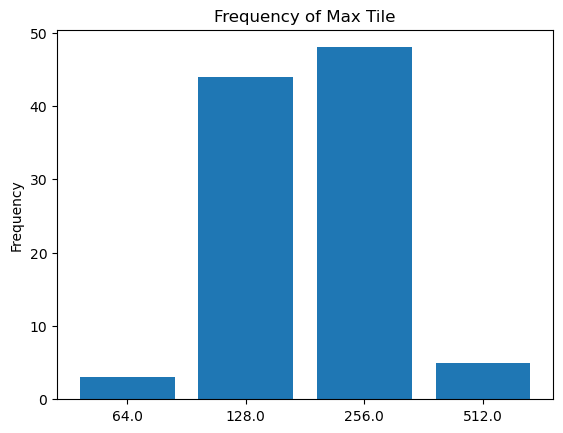

In [ ]:
import matplotlib.pyplot as plt

# Count the frequency of each max_tile value
max_tile_counts = np.bincount(max_tiles.astype(int))
max_tile_counts = max_tile_counts[max_tile_counts>0]

unique_max_tiles = np.unique(max_tiles)
# Create a bar chart
plt.bar(np.arange(len(unique_max_tiles)), max_tile_counts)
plt.xticks(np.arange(len(unique_max_tiles)), unique_max_tiles)

# Set the y-axis label
plt.ylabel('Frequency')

# Set the title
plt.title('Frequency of Max Tile')

# Show the plot
plt.show()

